# Compare Two 1-bit Binary Numbers


In [44]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, AerProvider


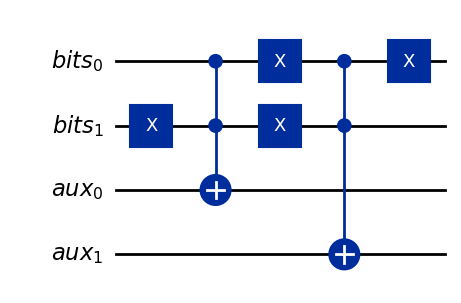

In [10]:
def bit_compare():
    qr = QuantumRegister(2, "bits")
    aux = QuantumRegister(2, "aux")
    
    qc = QuantumCircuit(qr, aux)
    qc.x(qr[1])
    qc.mcx(qr, aux[0])
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr, aux[1])
    qc.x(qr[0])
    
    return qc

bit_compare().draw("mpl")

In [4]:
def encode(number):
    qr = QuantumRegister(1, "number")
    qc = QuantumCircuit(qr)
    if (number == 1):
        qc.x(qr[0])
    return qc

In [19]:
def compare(a, b):
    qra = QuantumRegister(1, "a")
    qrb = QuantumRegister(1, "b")
    qraux = QuantumRegister(2, "aux")

    qc = QuantumCircuit(qra, qrb, qraux)

    qc.append(encode(a), [*qra])
    qc.append(encode(b), [*qrb])

    qc.append(bit_compare(), [*qra, *qrb, *qraux])

    # Tell Qiskit how to simulate our circuit
    backend = AerProvider.get_backend('statevector_simulator') 

    # Do the simulation, returning the result
    result = execute(qc,backend, shots=1000).result()

    # get the probability distribution
    counts = result.get_counts()
    
    return counts

In [20]:
counts = compare(0,1)
plot_histogram(counts)

TypeError: super(type, obj): obj must be an instance or subtype of type

# Compare Two n-bit strings 

In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

def bit_compare():
    qr = QuantumRegister(2, "bits")
    aux = QuantumRegister(2, "aux")
    
    qc = QuantumCircuit(qr, aux)
    qc.x(qr[1])
    qc.mcx(qr, aux[0])
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr, aux[1])
    qc.x(qr[0])
    
    return qc

In [28]:
def encode(bit):
    qr = QuantumRegister(1, "number")
    qc = QuantumCircuit(qr)
    if (bit == "1"):
        qc.x(qr[0])
    return qc

The encode function takes a single-bit character. So, to encode an entire bitstring, we need to call this function multiple times.

In [52]:
from qiskit import ClassicalRegister
# Create circuit with qubits for bitstring a and b + Auxs for caclulation
def compare_bitstring(bitstring_a, bitstring_b, exec=True):
    bits = len(bitstring_a)
    qra = QuantumRegister(bits, "a")
    qrb = QuantumRegister(bits, "b")
    qraux = QuantumRegister(2*bits, "aux")
    qrint = QuantumRegister(bits-1, "int")
    cr = ClassicalRegister(2)

    qc = QuantumCircuit(qra, qrb, qraux, qrint, cr)

    for i in range(bits):
        qc.append(encode(bitstring_a[i]), [qra[i]])
        qc.append(encode(bitstring_b[i]), [qrb[i]])
        qc.append(bit_compare(), [qra[i], qrb[i], qraux[2*i], qraux[2*i+1]])
        
        if i < bits-1:
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
            qc.mcx([qraux[2*i], qraux[2*i+1]], qrint[i])
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
        
    for i in range(0, bits-1):
        qc.mcx([qraux[2*(-i-1)],  qrint[-i]], qraux[2*(-i)])
        qc.mcx([qraux[2*(-i-1)+1],  qrint[-i]], qraux[2*(-i)+1])
        
    qc.measure(qraux[0], cr[0])
    qc.measure(qraux[1], cr[1])
    
    if exec:
        # Transpile for simulator
        simulator = AerSimulator()
        circ = transpile(qc, simulator)
        
        # Run and get counts
        result = simulator.run(circ, shots=1000).result()
        counts = result.get_counts(circ)

        return counts
    else:
        return qc

The compare_bitstring function takes two bitstrings as input parameters. Further, we can specify whether we want to execute (exec) the circuit right away and return the results, or whether we want to get back the circuit (exec=False).

1. First, we calculate the number of bits (qubits) we require to represent the numbers. We expect both numbers to have the same length. So, if one number is smaller than the other, we would need to add leading zeros.
2. qraux contains the auxiliary qubits we need to compare single digits. Since we need two of them to compare a single digit, we need 2*bits of them.
3. The qrint register further contains “intermediate” qubits that we need to connect the results of comparing single digits.

In [53]:
compare_bitstring('100','011')

{'01': 1000}